In [1]:
%reset
%load_ext autoreload
%autoreload 2

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
import matplotlib.gridspec as gridspec

from info.core.ccm import ccm, extended_ccm, find_embedded_lag
from info.plot import plot_ccm
from info.models.logistic_network import Logistic
from info.models.others import Lorenze_model, fishery_model, two_species_logistic, two_species_logistic_delayed
from info.utils.others import corrcoefs
from info.utils.sst import conductSST_withlag, conductSST_CCM, conductSST_CCM_librarylengths

In [3]:
# Settings for plot
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20

## 1. The selection of tau and E
**The goal of this section is to see whether the average mutual information method is appropiate for finding the best lag for CCM.**

### 1.1. Lorenze Model
First, we'll show the reasonality of the coded average mutual information in Lorenze model.

Ref: Fig 3.4 in http://download.springer.com/static/pdf/861/chp%253A10.1007%252F978-1-4612-0763-4_3.pdf?originUrl=http%3A%2F%2Flink.springer.com%2Fchapter%2F10.1007%2F978-1-4612-0763-4_3&token2=exp=1491253174~acl=%2Fstatic%2Fpdf%2F861%2Fchp%25253A10.1007%25252F978-1-4612-0763-4_3.pdf%3ForiginUrl%3Dhttp%253A%252F%252Flink.springer.com%252Fchapter%252F10.1007%252F978-1-4612-0763-4_3*~hmac=d0a15e822157cbaf208a2e497fabc8efc079d2a9441d374b46a4ab6df663b9e9

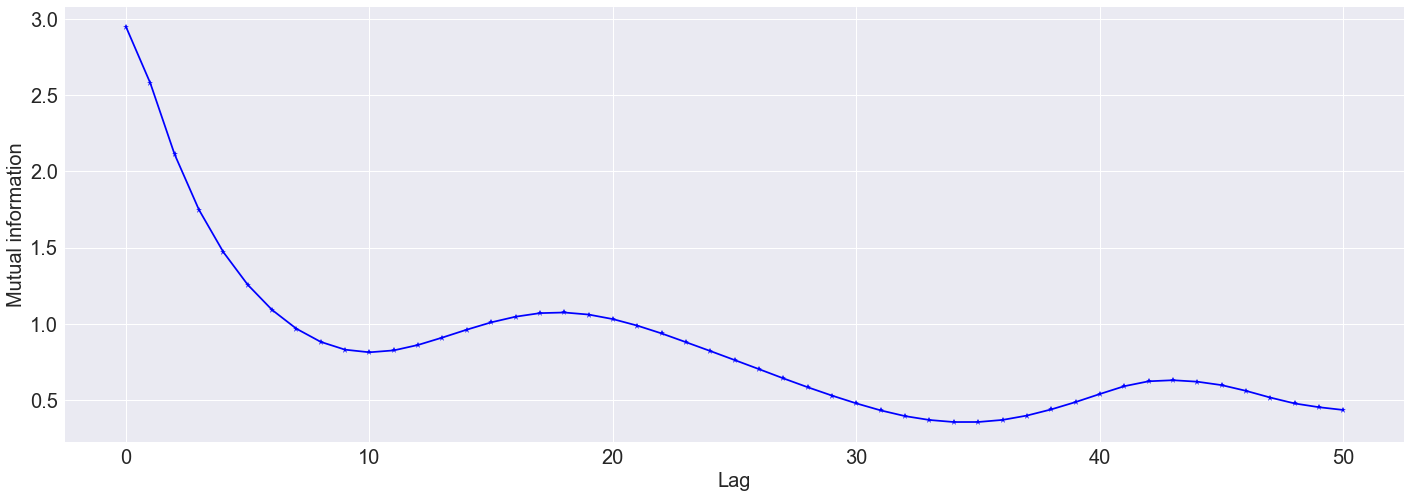

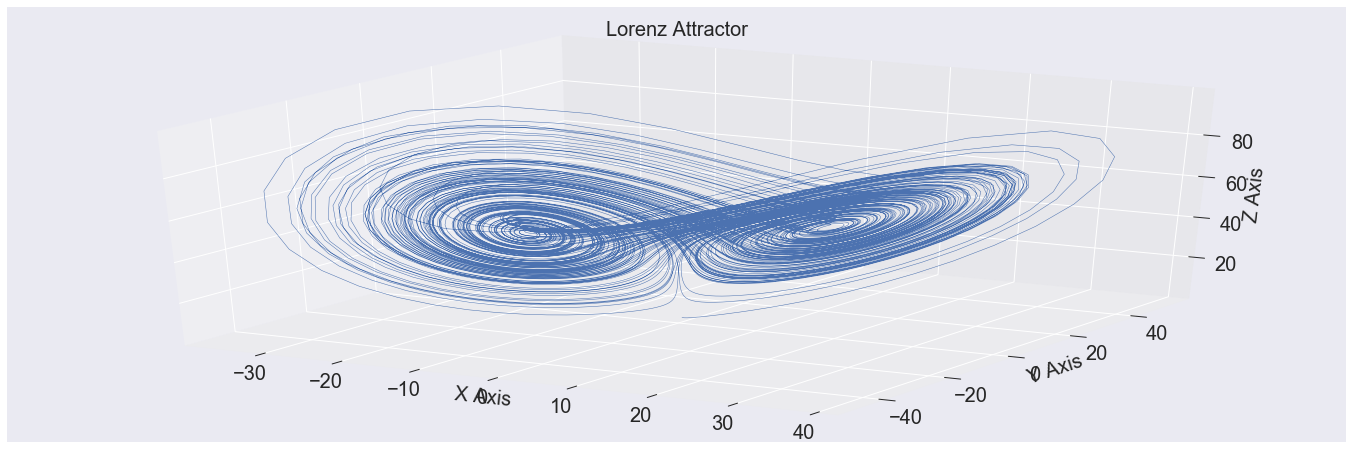

In [97]:
### The change of correlation coefficients versus time lengths
# Parameter settings
sigma, r, b = 16., 45.92, 4.
x0, y0, z0  = 0., 1., 1.05
tau_set = range(1, 11, 2)
E_set = range(2, 12, 2)
tsize = len(tau_set)
Esize = len(E_set)
L = 5000
dt = .01
tauspe = 0

# Simulation
x_set, y_set, z_set = Lorenze_model(x0, y0, z0, L+L, dt, sigma, r, b)
x, y = x_set[:L], y_set[:L]
x_future, y_future = x_set[L:], y_set[L:]

tbestx, misetx, tsetx = find_embedded_lag(x, 50)
tbesty, misety, tsety = find_embedded_lag(y, 50)

plt.plot(tsetx, misetx, 'b*-')
plt.xlabel('Lag')
plt.ylabel('Mutual information')


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x_set, y_set, z_set, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

### 1.2. Two coupled logistic equations
\begin{aligned}
x(t+1) &= x(t)[r_x-r_x x(t)-b_{xy}y(t)] \\
y(t+1) &= y(t)[r_y-r_y y(t)-b_{yx}x(t)]
\end{aligned}

It can be shown here that the average mutual information is not able to predict the best lag for CCM. 

**It's probably due to the unchanged time step might be too large.** Unfortunately, the time step of the collected data can not be changed. Therefore, the average mutual information is not suggested used for detecting the best lag for reconstructing the manifold in CCM.

Instead, the pure test of CCM on different combination of E and tau (i.e., the lag) is recommended, which is also utilized in most CCM applications.

         E   tau
xmpy:     4    1
ympx:     2    1



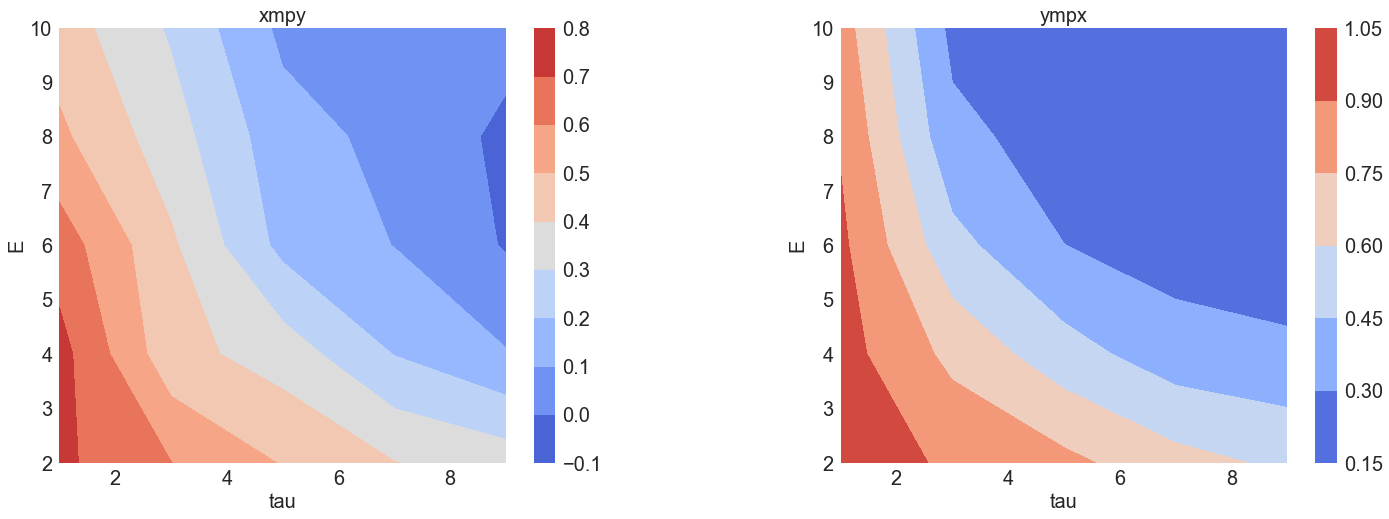

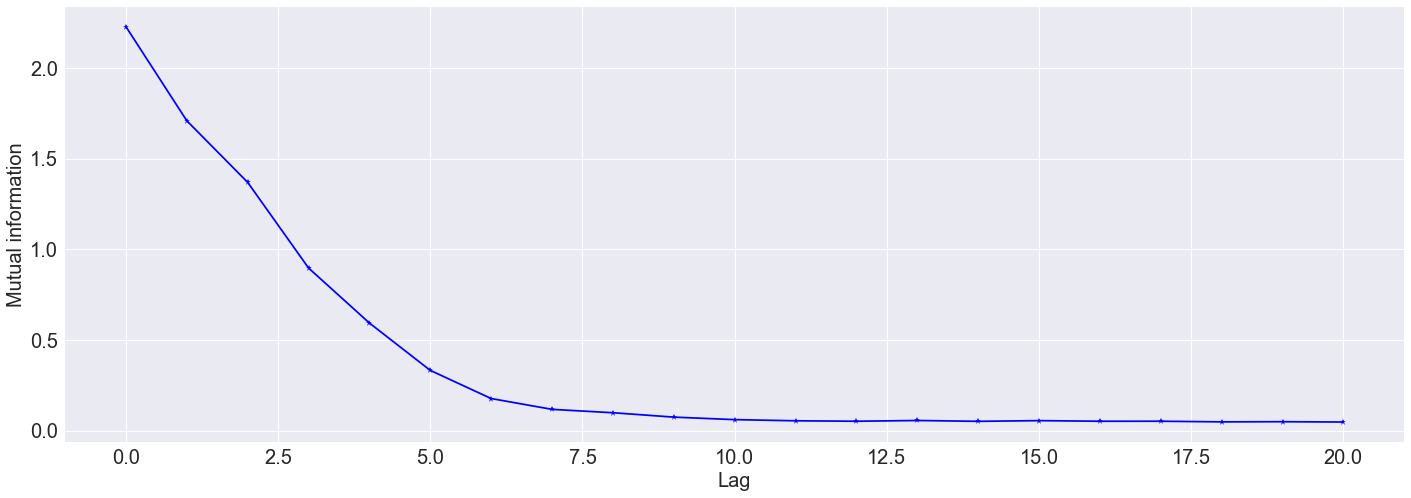

In [117]:
### The change of correlation coefficients versus time lengths
# Parameter settings
bxy, byx = .02, .1
rx, ry = 3.8, 3.5
x0, y0 = .4, .2
tau_set = range(1, 11, 2)
E_set = range(2, 12, 2)
tsize = len(tau_set)
Esize = len(E_set)
L = 1000
tauspe = 0

# Simulation
x_set, y_set = two_species_logistic_delayed(x0, y0, L+L, rx, ry, bxy, byx, tauspe)
x, y = x_set[:L], y_set[:L]
x_future, y_future = x_set[L:], y_set[L:]

# Compute rho for different lengths of the time series
xmpy, ympx = np.zeros([tsize, Esize]), np.zeros([tsize, Esize])
for i in range(tsize):
    tau = tau_set[i]
    for j in range(Esize):
        E = E_set[j]
        _, rho1 = ccm(x, y, x_future, y_future, E, tau)
        _, rho2 = ccm(y, x, y_future, x_future, E, tau)
        xmpy[i, j] = rho1
        ympx[i, j] = rho2

# Get the values of E and tau for the maximum xmpy and ympx
ind1, ind2 = xmpy.argmax(), ympx.argmax()
txmpy, Exmpy = ind1 / tsize, ind1 % tsize
tympx, Eympx = ind2 / tsize, ind2 % tsize
print '         E   tau'
print 'xmpy:     %d    %d' % (E_set[Exmpy], tau_set[txmpy])
print 'ympx:     %d    %d' % (E_set[Eympx], tau_set[tympx])
print ''

# Compute the mutual information
tbestx, misetx, tsetx = find_embedded_lag(x, 20)
tbesty, misety, tsety = find_embedded_lag(y, 20)

# Plot
xv, yv = np.meshgrid(tau_set, E_set, indexing='ij')
plot_ccm.plot_ccm_xy(xmpy, ympx, xv, yv, 'tau', 'E')

plt.figure()
plt.plot(tsetx, misetx, 'b*-')
plt.xlabel('Lag')
plt.ylabel('Mutual information')

plt.show()

### 2. Significance test -- An example in the two coupled logistic equations 

**The goal of this section is to test the feasiliby of applying the significance test in determining the significance of the CCM skills**

In [33]:
### The change of correlation coefficients versus time lengths
# Parameter settings
bxy, byx = .1, .1
rx, ry = 3.8, 3.8
x0, y0 = .4, .2
tauxy, tauyx = 1, 1
Exy, Eyx = 4, 2
L_set = np.arange(40, 1000, 20)
Lsize = L_set.size
tauspe = 0

### 2.1. The significance test based on the normal shuffling method

In [43]:
# sst method
sstmethod = 'traditional'

rxy_set, ryx_set     = np.zeros(Lsize), np.zeros(Lsize)
rhoxy_set, rhoyx_set = np.zeros(Lsize), np.zeros(Lsize)
uxy_set, uyx_set     = np.zeros(Lsize), np.zeros(Lsize)
lxy_set, lyx_set = np.zeros(Lsize), np.zeros(Lsize)

# Simulation
x, y = two_species_logistic_delayed(x0, y0, L_set[-1], rx, ry, bxy, byx, tauspe)

rxy_set, rhoxy_set, lxy_set, uxy_set = conductSST_CCM_librarylengths(L_set, x, y, nemb=Exy, 
                                                                     tau=tauxy, sstmethod=sstmethod)
ryx_set, rhoyx_set, lyx_set, uyx_set = conductSST_CCM_librarylengths(L_set, y, x, nemb=Eyx, 
                                                                     tau=tauyx, sstmethod=sstmethod)

# for i in range(Lsize):
#     # Simulation
#     x, y = two_species_logistic_delayed(x0, y0, L_set[i], rx, ry, bxy, byx, tauspe)

#     # Significant test
#     rxy, rhoxy, uxy, lxy, = conductSST_CCM(x, y, nemb=Exy, tau=tauxy, sstmethod=sstmethod)
#     ryx, rhoyx, uyx, lyx, = conductSST_CCM(y, x, nemb=Eyx, tau=tauyx, sstmethod=sstmethod)
    
#     rxy_set[i], ryx_set[i] = rxy, ryx
#     rhoxy_set[i], rhoyx_set[i] = rhoxy, rhoyx
#     uxy_set[i], uyx_set[i] = uxy, uyx
#     lxy_set[i], lyx_set[i] = lxy, lyx

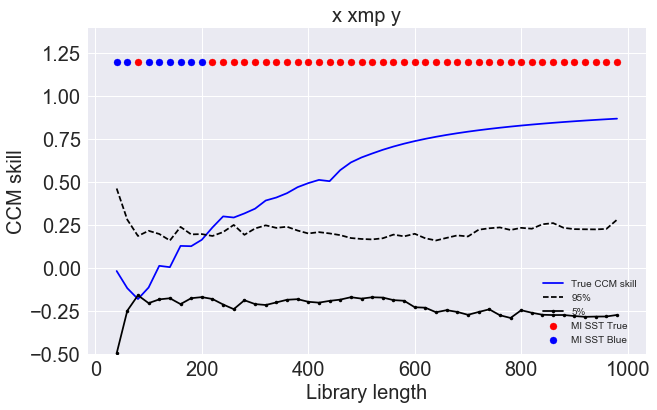

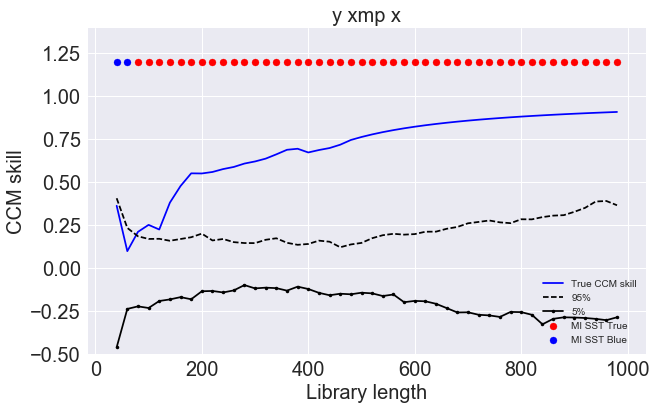

In [44]:
# Plot
plot_ccm.plot_ccm_with_sst(L_set, rxy_set, rhoxy_set, uxy_set, lxy_set, title='x xmp y')
plot_ccm.plot_ccm_with_sst(L_set, ryx_set, rhoyx_set, uyx_set, lyx_set, title='y xmp x')
plt.show()

### 2.2. The significance test based on the 'segment' method

In [41]:
# sst method
sstmethod = 'segments'

rxy_set, ryx_set     = np.zeros(Lsize), np.zeros(Lsize)
rhoxy_set, rhoyx_set = np.zeros(Lsize), np.zeros(Lsize)
uxy_set, uyx_set     = np.zeros(Lsize), np.zeros(Lsize)
lxy_set, lyx_set = np.zeros(Lsize), np.zeros(Lsize)

# Simulation
x, y = two_species_logistic_delayed(x0, y0, L_set[-1], rx, ry, bxy, byx, tauspe)

rxy_set, rhoxy_set, lxy_set, uxy_set = conductSST_CCM_librarylengths(L_set, x, y, nemb=Exy, 
                                                                     tau=tauxy, sstmethod=sstmethod)
ryx_set, rhoyx_set, lyx_set, uyx_set = conductSST_CCM_librarylengths(L_set, y, x, nemb=Eyx, 
                                                                     tau=tauyx, sstmethod=sstmethod)

# for i in range(Lsize):
#     # Simulation
#     x, y = two_species_logistic_delayed(x0, y0, L_set[i], rx, ry, bxy, byx, tauspe)

#     # Significant test
#     rxy, rhoxy, uxy, lxy, = conductSST_CCM(x, y, nemb=Exy, tau=tauxy, sstmethod=sstmethod)
#     ryx, rhoyx, uyx, lyx, = conductSST_CCM(y, x, nemb=Eyx, tau=tauyx, sstmethod=sstmethod)
    
#     rxy_set[i], ryx_set[i] = rxy, ryx
#     rhoxy_set[i], rhoyx_set[i] = rhoxy, rhoyx
#     uxy_set[i], uyx_set[i] = uxy, uyx
#     lxy_set[i], lyx_set[i] = lxy, lyx

1 980
1 980


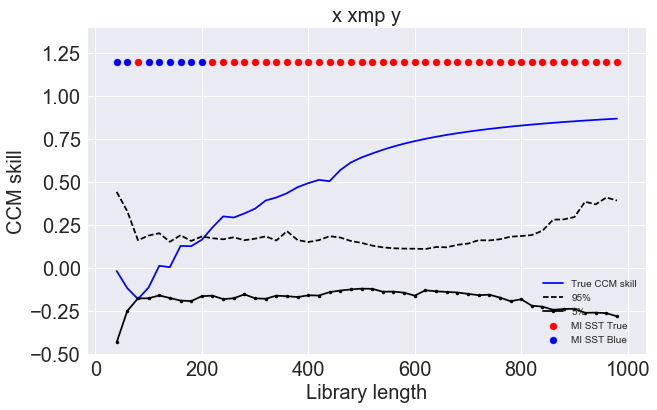

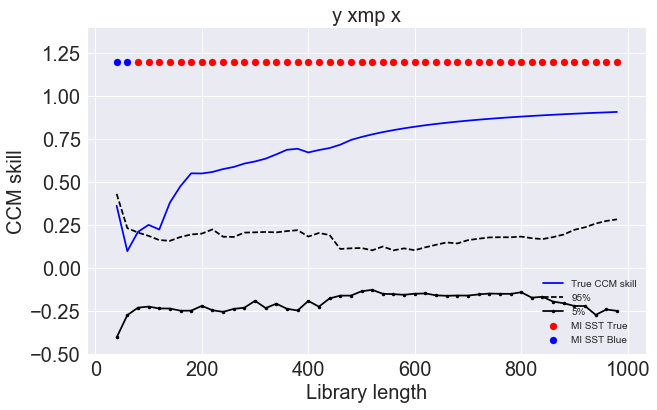

In [42]:
# Plot
plot_ccm.plot_ccm_with_sst(L_set, rxy_set, rhoxy_set, uxy_set, lxy_set, title='x xmp y')
plot_ccm.plot_ccm_with_sst(L_set, ryx_set, rhoyx_set, uyx_set, lyx_set, title='y xmp x')
plt.show()

In [61]:
# x, y = two_species_logistic_delayed(x0, y0, L_set[1], rx, ry, bxy, byx, tauspe)
# x_future, y_future = x, y

# # Significant test
# rxy, rhoxy, uxy, lxy, = conductSST_CCM(x, y, Exy, tauxy, sstmethod=sstmethod)
# ryx, rhoyx, uyx, lyx, = conductSST_CCM(y, x, Eyx, tauyx, sstmethod=sstmethod)